# PointNet Pytorch Implementation

This notebook replicates the Neural Network used for Point Cloud classification.
The original PointNet was created using Tensorflow (no Keras)

* Original Code: https://github.com/charlesq34/pointnet

* Paper: https://arxiv.org/pdf/1612.00593.pdf

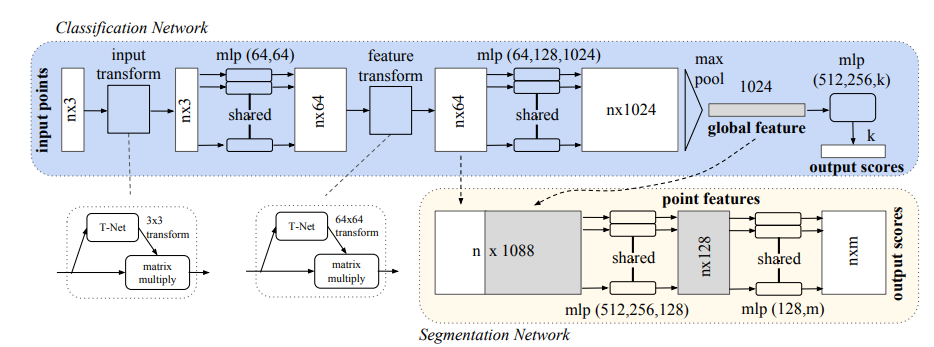

## Imports

In [1]:
import os
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F

## T-net (Transformation Network)

* Based on the Spatial Transformer Network: https://arxiv.org/pdf/1506.02025.pdf

T-net is a network that predicts a tranformation matrix (3x3 for input transform, 64x64 for feature transform) that will transform the pointclouds (rotate, etc).

This makes the network be unaffected by the different alignments of the input point clouds 

> Details on the Pointnet Paper found at the supplementary `C. Network Architecture and Training Details
(Sec 5.1)`

> Original TF implementation: https://github.com/charlesq34/pointnet/blob/master/models/transform_nets.py

In [2]:
class SpatialTransformNet(nn.Module):
    """
    T-net
    Outputs a kxk transformation matrix
    """
    def __init__(self, k=3):
        super(SpatialTransformNet, self).__init__()
        self.k = k
        # the first conv1d from the input transform has a kernel size of 3 on original
        self.conv1 = nn.Conv1d(k, 64, 1) 
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        # use torch.max on the third axis instead of maxpooling
        # that way, we dont need the number of points to initialize it
        # self.mpool = nn.MaxPool1d(num_points) 
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        # using a fully connected layer with k*k output instead of the original matmul system
        self.fc3 = nn.Linear(256, k*k) # this is the output k*k matrix
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256) 

    def forward(self, x):
        # input shape = (batch_size, 3, num_points)
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # shape = (batch_size, 1024, num_points)
        
        # maxpooling the highest value on each point
        x = torch.max(x, 2, keepdim=True)[0]
        # shape = (batch_size, 1024, 1)
        x = x.view(-1, 1024) 
        # shape = (batch_size, 1024)
        
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        # shape = (batch_size, 256)

        # output
        x = self.fc3(x) 
        # shape = (batch_size, k*k)
        # add identity matrix as bias
        bias = torch.eye(self.k).flatten().repeat(batchsize, 1)
        # bias shape = (batch_size, k*k)
        if x.is_cuda:
            bias = bias.cuda()
        x = x + bias
        
        # reshape output into k x k matrix
        x = x.view(-1, self.k, self.k)
        # shape = (batch_size, k, k)
        
        return x

In [3]:
example_tensor = torch.randn((4, 3, 5))
example_tensor

tensor([[[ 0.2190, -2.4720, -0.3880, -2.0083,  0.4657],
         [ 0.2266, -0.7574,  0.7277,  1.6169, -0.3815],
         [ 0.5724,  0.4477,  0.7598,  0.5942, -0.4763]],

        [[ 1.8344,  0.1454,  0.2244, -2.1529,  0.4078],
         [ 0.2459,  0.9683,  0.1305, -1.0373,  1.3641],
         [ 0.1121,  0.4236,  1.0468, -0.3638,  2.1959]],

        [[ 0.7430,  0.0606, -1.0155, -1.4339, -0.9517],
         [-0.5561, -0.5376, -0.1236, -2.0649, -0.2624],
         [-1.0392, -0.7621,  0.9910,  1.6877, -0.6992]],

        [[-0.9532,  0.5329, -0.7645,  0.0909,  1.7976],
         [ 0.5339,  0.2238, -0.1001, -0.2887,  1.4016],
         [ 0.6080,  0.2840, -1.9564,  2.2543,  0.4832]]])

In [4]:
# function to get most important points per batch from maxpool
# torch.argmax(example_tensor, 2, keepdim=False) 

In [5]:
tnet = SpatialTransformNet(k=3)

In [6]:
result = tnet(example_tensor)
result.shape

torch.Size([4, 3, 3])

## PointNet Feature

Network that returns the global feature 1x1024 global feature vector.
It can also return the identifier of the main points used for the prediction, by returning the points selected by the last max pooling layer.

If 3d segmentation needs to be implemented, it can returns the n x 64 per-point features concatenated with the global feature, resulting in the n x 1088 input vector to the segmentation network.

> Original code can be found at: https://github.com/charlesq34/pointnet/blob/master/models/pointnet_cls.py

> Used https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py for pytorch reference

In [7]:
class PointNetFeature(nn.Module):
    """
    Pointnet core, with no classification or segmentation head
    Outputs either the global 1 x 1024 global feature vector or the
    n x 1088 segmentation feature vector
    """
    def __init__(self, segmentation=False):
        super(PointNetFeature, self).__init__()
        self.segmentation = segmentation
        # input transform
        self.input_tnet = SpatialTransformNet(k=3)
        
        # mlp (64, 64)
        # the first conv1d from the input transform has a kernel size of 3 on original
        self.conv1 = nn.Conv1d(3, 64, 1) 
        self.conv2 = nn.Conv1d(64, 64, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        
        # feature transform
        self.feature_tnet = SpatialTransformNet(k=64)
        
        # mlp (64, 128, 1024)
        self.conv3 = nn.Conv1d(64, 64, 1) 
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.conv5 = nn.Conv1d(128, 1024, 1)
        
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        

    def forward(self, x):
        # input shape = (batch_size, 3, num_points)   
        batchsize = x.size()[0]
        num_points = x.size()[2]
        
        # input transform
        input_transform = self.input_tnet(x)
        # input transform shape = (batch_size, 3, 3)
        x = x.transpose(1, 2)
        # x shape = (batch_size, num_points, 3)
        x = torch.matmul(x, input_transform)
        #shape = (batch_size, num_points, 3) 
        x = x.transpose(1, 2)
        # shape = (batch_size, 3, num_points) 
        
        # mlp (64, 64)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        # shape = (batch_size, 64, num_points) 
        
        # feature transform
        feature_transform = self.feature_tnet(x)
        # feature transform shape = (batch_size, 64, 64)
        x = x.transpose(1, 2)
        # x shape = (batch_size, num_points, 64)
        x = torch.matmul(x, feature_transform)
        #shape = (batch_size, num_points, 64) 
        x = x.transpose(1, 2)
        # shape = (batch_size, 64, num_points)
        # save features of all points for segmentation use
        point_features = x
           
        # mlp (64, 128, 1024)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        # shape = (batch_size, 1024, num_points)
        
        # maxpooling the highest value on each point
        max_pool = torch.max(x, 2, keepdim=True)
        # index 1 of maxpool contains the indices of the chosen points
        # which means those are the main points used for predictions
        # remove last dimension so it returns a tensor with shape (batch_size, 1024)
        main_points = max_pool[1].squeeze(dim=2)
        # save the main points of the batch for future checking
        # index 0 of maxpool contains the maxpool result values
        x = max_pool[0]
        # shape = (batch_size, 1024, 1)
        
        # for segmentation, concatenate global feature to the (n x 64) point features
        if self.segmentation:
            # repeath the global feature to attach it after each point feature
            x = x.repeat(1, 1, num_points)
            # shape = (batch_size, 1024, num_points)
            x = torch.cat((point_features, x), 1)
            # shape = (batch_size, 1088, num_points)
        
        else:
            # remove the last dimension of the tensor with shape (batch_size, 1024, 1)
            # but avoid removing the batch_size dimension if it's 1 using dim=2
            x = x.squeeze(dim=2)
            # shape = (batch_size, 1024)
        
        # return main points and input transform matrix for my own curiosity
        # return feature transform matrix to compute the regularization term
        return x, main_points, input_transform, feature_transform

In [8]:
# classification
example_tensor = torch.randn((4, 3, 5))
feature_net = PointNetFeature(segmentation=False)
result, main_points, input_transf, feature_transf = feature_net(example_tensor)
print(f"Classification feature shape: {result.shape}")

Classification feature shape: torch.Size([4, 1024])


In [9]:
# segmentation
example_tensor = torch.randn((4, 3, 5))
feature_net = PointNetFeature(segmentation=True)
result, main_points, input_transf, feature_transf = feature_net(example_tensor)
print(f"Segmentation feature shape: {result.shape}")

Segmentation feature shape: torch.Size([4, 1088, 5])


## PointNet Classification Head

Classification network that uses the global feature to classify Point Clouds in k classes

In [10]:
class PointNetClassifier(nn.Module):
    """
    PointNet classification Network
    Uses the PointNetFeature network
    """
    def __init__(self, num_classes=2):
        super(PointNetClassifier, self).__init__()
        self.num_classes = num_classes
        # Feature Network
        self.pointnet_feature = PointNetFeature(segmentation=False)
        # mlp (512, 256, num_classes)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.softmax = nn.Softmax(dim=1) # optional use of LogSoftmax
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        batchsize = x.size()[0]
        # get thre global feature
        x, main_points, input_transform, feature_transform = self.pointnet_feature(x)

        # shape = (batch_size, 1024)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        # shape = (batch_size, 256)
        
        x = self.fc3(x)
        # shape(batch_size, num_classes)
        # softmax
        x = self.softmax(x)
        
        # return main points and input transform matrix for my own curiosity
        # return feature transform matrix to compute the regularization term
        return x, main_points, input_transform, feature_transform

In [11]:
# classification
example_tensor = torch.randn((4, 3, 10000))
pointnet_cls = PointNetClassifier(num_classes=2)
result, main_points, input_transf, feature_transf = pointnet_cls(example_tensor)
print(f"Classification output shape: {result.shape}")

Classification output shape: torch.Size([4, 2])
